In [1]:
import sys
import os
# sys.path.append('/home/beinhaud/diplomka/mcs-source/evaluation_tools')
sys.path.append('/home/david/source/diplomka/evaluation_tools')
sys.path.append('/home/david/source/diplomka/results_analysis_tools')
from typing import List, Dict, Any, Tuple, Union

from evaluation_tools.plugins.predictions_analyzer import PredictionsAnalyzer
from evaluation_tools.plugins.wandb_processor import WandbProcessor
from evaluation_tools.fields.experiment_parameters_fields import WandbExperimentVariants, GridSearchRunVariants, ModelEvaluationRunVariant, AdditionalExperiments
from evaluation_tools.fields.prediction_analysis_fields import (
    BatchSummaryFields,
    EvaluationPairsVariants,
    VisibilityVariants
)
from evaluation_tools.fields.dataset_analyzer_fields import AnalysisFields, DatasetVariantField
from evaluation_tools.fields.evaluation_processor_fields import EvaluationProcessorChoices
from nn_model.type_variants import EvaluationFields
import nn_model.globals

import pandas as pd
import numpy as np

from results_analysis_tools.result_analyzer import ResultAnalyzer
from evaluation_tools.fields.dataset_parameters import ALL_TIME_STEP_VARIANTS
from results_analysis_tools.fields.experiment_analyses import (
    PlottingVariants,
    PluginVariants,
)
from results_analysis_tools.results_plotter import ResultsPlotter
from results_analysis_tools.plugins.dataset_results_processor import DatasetResultsProcessor

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

from evaluation_tools.fields.dataset_analyzer_fields import StatisticsFields
from results_analysis_tools.plugins.histogram_processor import DatasetHistogramProcessor
from results_analysis_tools.plugins.temporal_evolution_processor import TemporalEvolutionProcessor
from results_analysis_tools.plugins.synchrony_experiments_processor import SynchronyExperimentsProcessor
from results_analysis_tools.plugins.evaluation_results_processor import EvaluationResultsProcessor
from results_analysis_tools.plugins.wandb_summary_processor import WandbSummaryProcessor
from results_analysis_tools.plugins.batch_prediction_analysis_processor import BatchPredictionAnalysisProcessor

from nn_model.globals import MODEL_SIZES


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np  # Needed for np.linspace

def plot_comparison_synchrony_curves_across_layers(df: pd.DataFrame, save_fig: str = "", title: str = ""):
    """
    Plot synchrony curves across layers (columns) for multiple models (rows),
    labeling only the leftmost plots of each row with A, B, C and adding a bottom legend.
    """
    ordered_layers = ["V1_Exc_L4", "V1_Exc_L23", "V1_Inh_L4", "V1_Inh_L23"]
    df["layer_name"] = pd.Categorical(df["layer_name"], categories=ordered_layers, ordered=True)
    
    pretty_layer_names = {
        "V1_Exc_L4": "L4 Excitatory ",
        "V1_Exc_L23": "L2/3 Excitatory ",
        "V1_Inh_L4": "L4 Inhibitory ",
        "V1_Inh_L23": "L2/3 Inhibitory ",
    }

    ordered_models = [
        "all",
        "visible",
        "invisible"
    ]
    row_labels = ['all', 'visible', 'invisible']
    # df["model_variant"] = pd.Categorical(df["model_variant"], categories=ordered_models, ordered=True)
    df.columns.name = None
    df["time_ms"] = df["time"] * 20

    g = sns.relplot(
        data=df,
        x="time_ms",
        y="synchrony",
        kind="line",
        hue="variant_type",
        style="variant_type",
        row="visibility_variant",
        col="layer_name",
        # facet_kws={"sharey": 'col', "sharex": True},
        facet_kws={"sharey": False, "sharex": True},
        height=4,
        aspect=1.25,
        linewidth=3,
        errorbar=None,
        palette="colorblind"
    )

    # Add vertical stimulus change line
    def add_vline(data, color, **kwargs):
        plt.axvline(
            nn_model.globals.IMAGE_DURATION,
            color="gray",
            linestyle="--",
            linewidth=2.2,
        )
    g.map_dataframe(add_vline)

    # Add grid lines
    g.map(lambda *args, **kwargs: plt.grid(True, linestyle=":", linewidth=0.4, alpha=0.6))
    
    g.figure.suptitle(title, fontsize=30, y=1.01)

    # Axis labels
    g.set_axis_labels("Time (ms)", "Ratio of Spiking Neurons", size=17)
    g.set_titles("")  # Remove col/row template titles

    # Annotate each row
    for i, ax_row in enumerate(g.axes):
        ax = ax_row[0]
        ax.annotate(
            row_labels[i],
            xy=(0, 1.15),
            xycoords='axes fraction',
            xytext=(-0.1, 1.15),
            textcoords='axes fraction',
            fontsize=20,
            fontweight='bold',
            va='center',
            ha='center',
            annotation_clip=False
        )

    # Y-axis: 4 ticks per subplot
    num_ticks = 4
    for ax in g.axes.flat:
        ymin, ymax = ax.get_ylim()
        fixed_yticks = np.linspace(ymin, ymax, num_ticks)
        ax.set_yticks(fixed_yticks)
        ax.set_yticklabels([f"{y:.4f}" for y in fixed_yticks], fontsize=12)
        ax.tick_params(axis='both', labelsize=12)

    # Column titles
    for i, ax in enumerate(g.axes[0]):
        ax.set_title(pretty_layer_names[ordered_layers[i]], fontsize=20)

    g.figure.tight_layout(rect=[0.05, 0, 1, 1])  # Leave space at bottom for legend

    # Custom legend at bottom, line by line
    stimulus_line = mlines.Line2D([], [], color="gray", linestyle="--", linewidth=2, label="Stimulus change")
    separator = mlines.Line2D([], [], color="black", linestyle="-", linewidth=0, label="────────────")
    handles, labels = g.axes.flat[0].get_legend_handles_labels()
    g._legend.remove()

    g.figure.legend(
        handles + [separator, stimulus_line],
        ["Predictions", "Target", "────────────", "Stimulus change"],
        loc="lower center",
        fontsize=15,
        title="Variant Type + Marker",
        title_fontsize=16,
        frameon=True,
        ncol=1,
        bbox_to_anchor=(0.0, 0.05)
    )

    if save_fig:
        g.figure.savefig(save_fig, format="pdf", bbox_inches="tight")
    else:
        plt.show()


In [6]:
visibility_ratio = 0.5
# visibility_ratio = 0.9

# reg_value = 0
# reg_value = 0.01
# reg_value = 1
# reg_value = 10
# reg_value = 0.0001

# model_variant = f"invisible_{visibility_ratio}"
# if reg_value != 0:
#     model_variant += f"_reg_{reg_value}"

model_variants = [
    "simple_10.0", 
    "dnn_10.0",
    "syn_adapt_10.0",
    "model_0.3", 
    "model_1.0.",
    "model_2.0_visible_0.5",
]

selected_variant_id = 4
model_variant = model_variants[selected_variant_id]

In [7]:
PLOTING_DESTINATION = "/home/david/source/diplomka/thesis_plots/"
EVALUATION_RESULTS_BASE = "/analysis_results"
CONFERENCE_BASE = "bernstein_conference/"
analysis_paths = {
    EvaluationProcessorChoices.FULL_DATASET_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.FULL_DATASET_ANALYSIS.value}/",
    EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS.value}/",
    EvaluationProcessorChoices.WANDB_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.WANDB_ANALYSIS.value}/results.pkl",
    EvaluationProcessorChoices.PREDICTION_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.PREDICTION_ANALYSIS.value}/",
}
analysis_paths[EvaluationProcessorChoices.PREDICTION_ANALYSIS] += CONFERENCE_BASE
result_analyzer = ResultAnalyzer(
    analysis_paths, load_custom_variant=model_variant,
)
# model_variant = "invisible_0.5"
plot_data = result_analyzer.prepare_dataframe_for_plot(
    PlottingVariants.SEPARATE_TEMPORAL_BEHAVIOR_TARGET_PREDICTION,
    synchrony_curve_kwargs={
        "model_variants": [model_variant],
    },
)

# Select only model subset 0
plot_data = plot_data[plot_data["subset_index"] == 0]
all_data = plot_data[plot_data['visibility_variant'] == VisibilityVariants.ALL_NEURONS]
visible_data = plot_data[plot_data['visibility_variant'] == VisibilityVariants.VISIBLE_NEURONS]
invisible_data = plot_data[plot_data['visibility_variant'] == VisibilityVariants.INVISIBLE_NEURONS]


File prediction_analysis-model_1.0..pkl does not exist. Skipping!


ValueError: No objects to concatenate

/tmp/ipykernel_26275/302226259.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_plot['synchrony'] /= diminisher


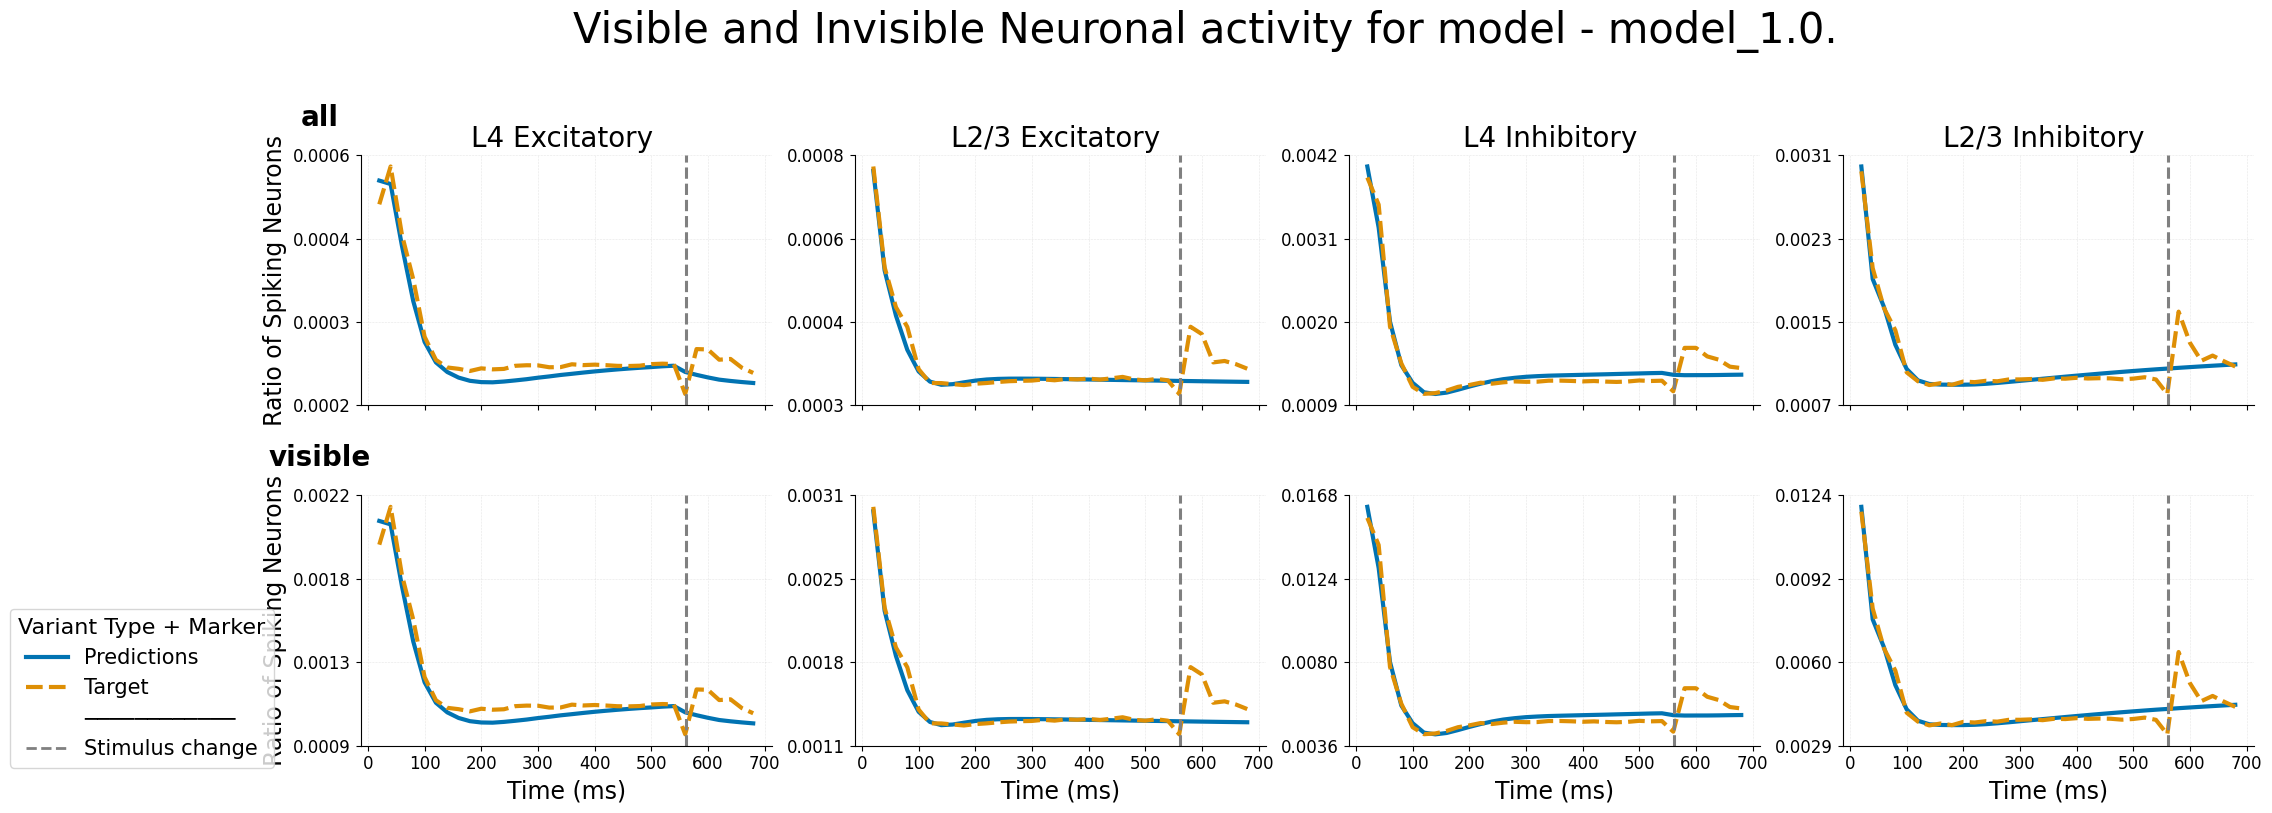

In [8]:
all_model_dfs = []

for variant, cur_plot in {
        VisibilityVariants.ALL_NEURONS: all_data, 
        VisibilityVariants.VISIBLE_NEURONS: visible_data, 
        VisibilityVariants.INVISIBLE_NEURONS: invisible_data
    }.items():
    # model_name_pretty = EvaluationResultsProcessor.model_names_mapping_for_plotting[model_variant]
    model_name_pretty = ["all, visible, invisible"]
    
    diminisher = 1
    if variant == VisibilityVariants.INVISIBLE_NEURONS:
        diminisher = 1 - visibility_ratio  # Because only half of neurons are used
    if variant == VisibilityVariants.VISIBLE_NEURONS:
        diminisher = visibility_ratio  # Because only half of neurons are used
    cur_plot['synchrony'] /= diminisher
    
    # cur_plot["model_variant"] = model_name_pretty  # Add column for comparison
    all_model_dfs.append(cur_plot)

combined_df = pd.concat(all_model_dfs, ignore_index=True)
plot_comparison_synchrony_curves_across_layers(
    combined_df, 
    save_fig=f"plots/combined_comparison_plot_{model_variant}.pdf", 
    title=f"Visible and Invisible Neuronal activity for model - {model_variant}",
)


In [15]:
print(model_variant)

invisible_0.5


/home/david/source/diplomka/results_analysis_tools/plotting/synchrony_curve_plotting.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["layer_name"] = pd.Categorical(


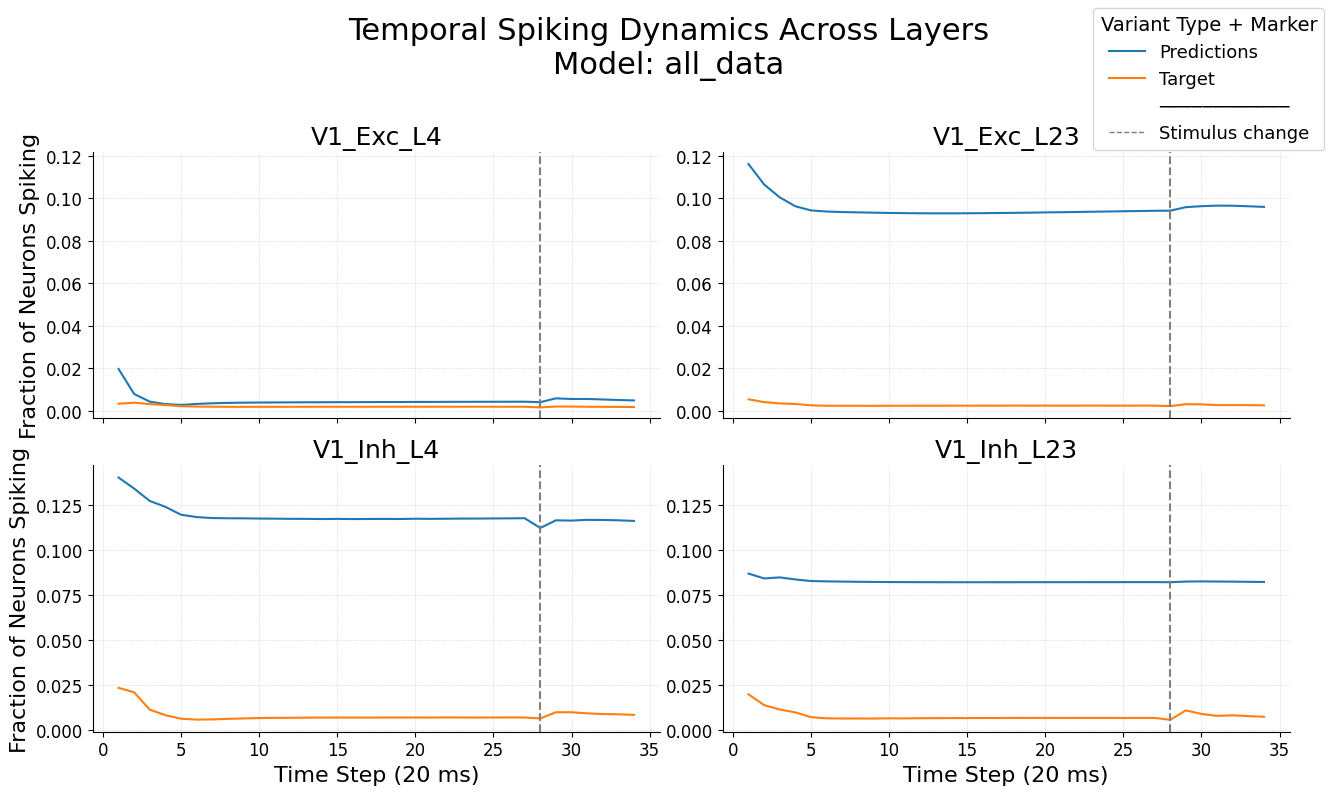

In [14]:
kwargs = {"model_variant": "all_data"}
filename = f"separate_model_synchrony_curve_{model_variant}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
ResultsPlotter.plot(all_data, PlottingVariants.SEPARATE_TEMPORAL_BEHAVIOR_TARGET_PREDICTION, save_fig=destination, kwargs=kwargs)

/home/david/source/diplomka/results_analysis_tools/plotting/synchrony_curve_plotting.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["layer_name"] = pd.Categorical(


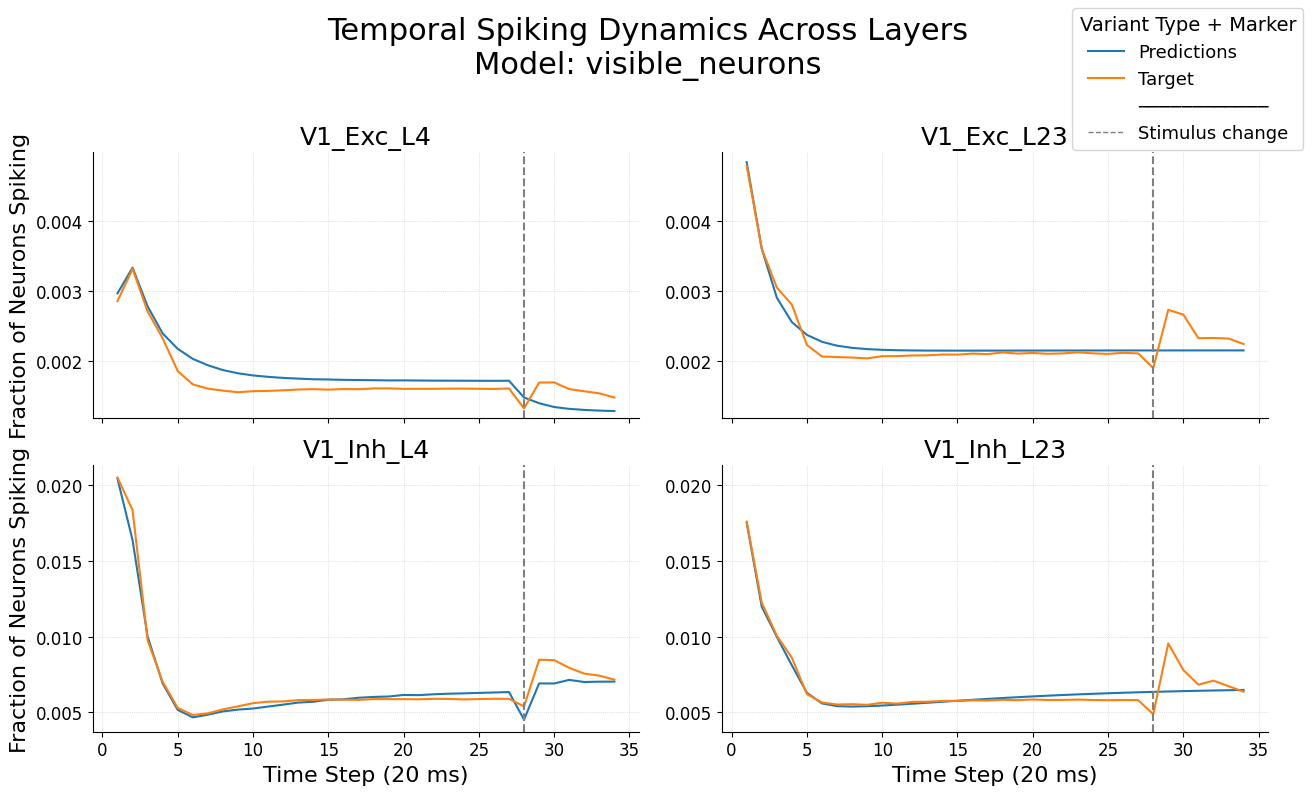

In [34]:
kwargs = {"model_variant": "visible_neurons"}
filename = f"separate_model_synchrony_curve_{model_variant}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
ResultsPlotter.plot(visible_data, PlottingVariants.SEPARATE_TEMPORAL_BEHAVIOR_TARGET_PREDICTION, save_fig=destination, kwargs=kwargs)

/home/david/source/diplomka/results_analysis_tools/plotting/synchrony_curve_plotting.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["layer_name"] = pd.Categorical(


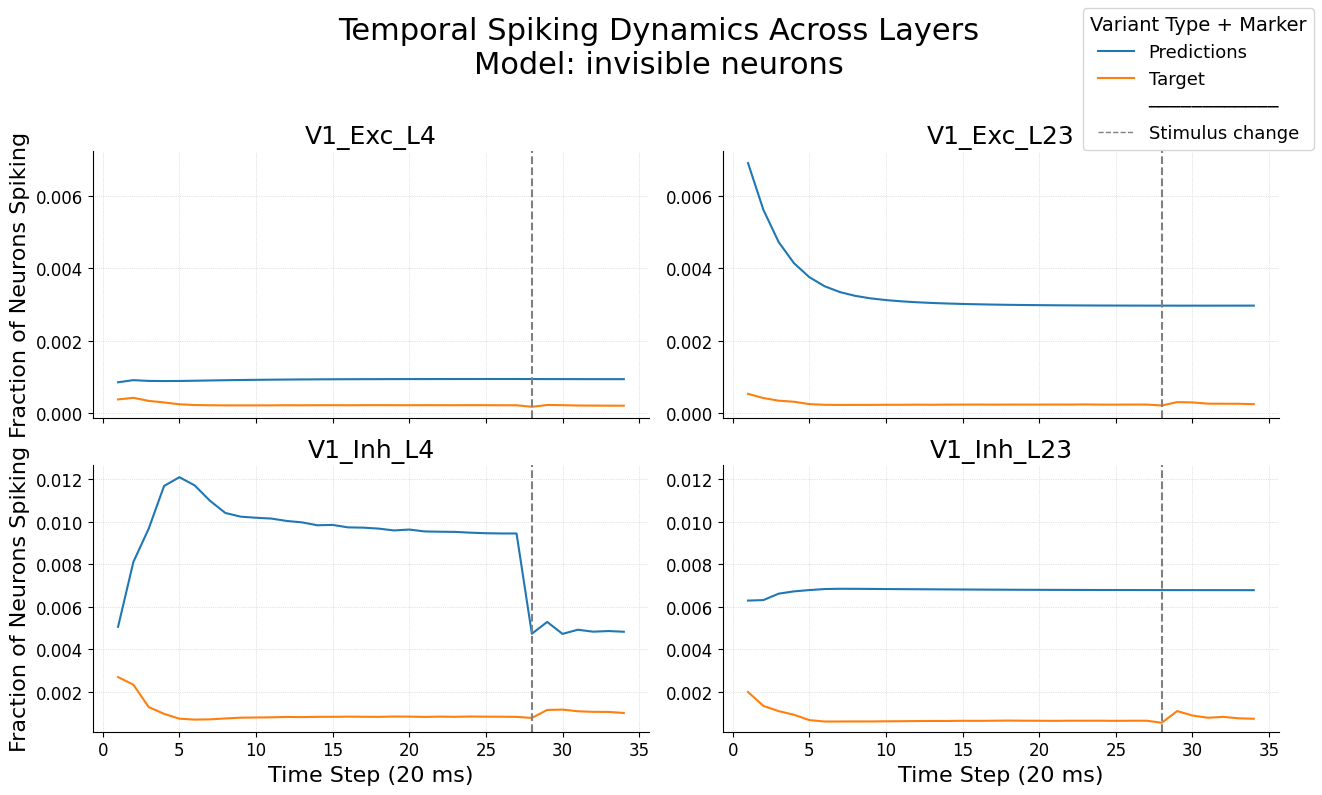

In [35]:
kwargs = {"model_variant": "invisible neurons"}
filename = f"separate_model_synchrony_curve_{model_variant}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
ResultsPlotter.plot(invisible_data, PlottingVariants.SEPARATE_TEMPORAL_BEHAVIOR_TARGET_PREDICTION, save_fig=destination, kwargs=kwargs)